In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl 
import seaborn as sns
# sns.set()
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.3, color_codes=True, rc=None)
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gpl
import json
import mapclassify
import matplotlib.ticker as ticker
from datetime import timedelta

%matplotlib inline

## Geo Data Processsing

Reading the initial zone shapefile and grouped zone (by FV)

In [4]:
#Handle naming and grouping
gpdzs = gpd.read_file('../../data/GEO DRC/RDC_Macro_Provinces.shp')#[['PROVINCE','Nom','geometry']]
gpdzsg = gpd.read_file('../../data/GEO DRC/RDC_Macro_Provinces.shp')#[['PROVINCE','Zone+Peupl','geometry']]

gpdzsg = gpdzsg.rename({'PROVINCE':'Nom'}, axis=1)
# gpdzsg['Nom'] =  gpdzsg['Nom']+'_g'

zone_filtered_gd = gpdzsg

# gpdzm = gpd.GeoDataFrame(pd.concat([gpdzs,gpdzsg], ignore_index=True), crs=gpdzsg.crs)

In [5]:
gpdzsg.head()

,Index,C0,C1,Surface,Nom,Population,geometry
0,22,0.415854,0.011909,52049.63,Sud-Ubangi,2 744 345,"POLYGON ((18.68941 1.90628, 18.68649 1.90233, ..."
1,7,0.458879,0.012838,54171.85,Nord-Ubangi,1 037 000,"POLYGON ((20.39471 2.82687, 20.38231 2.81683, ..."
2,2,0.451896,0.042421,56144.21,Mongala,1 793 564,"POLYGON ((21.63564 0.72938, 21.63387 0.72562, ..."
3,24,0.351923,0.003476,102527.71,Equateur,1 626 606,"POLYGON ((16.94268 -1.86609, 16.94502 -2.00127..."
4,8,0.247170,0.006137,132254.42,Tshuapa,1 316 855,"POLYGON ((21.84714 -2.53010, 21.84408 -2.53239..."


### Checking data issues

In [6]:
list_filtered_zones = list(zone_filtered_gd['Nom'])
print(list_filtered_zones,'size:',len(list_filtered_zones))

['Sud-Ubangi', 'Nord-Ubangi', 'Mongala', 'Equateur', 'Tshuapa', 'Maï-Ndombe', 'Kongo-Central', 'Kinshasa', 'Kwango', 'Kwilu', 'Kasaï', 'Kasaï-Central', 'Kasaï-Oriental', 'Lomami', 'Haut-Lomami', 'Lualaba', 'Haut-Katanga', 'Tanganyika', 'Nord-Kivu', 'Sud-Kivu', 'Maniema', 'Sankuru', 'Tshopo', 'Bas-Uele', 'Haut-Uele', 'Ituri'] size: 26


## Epidemiological Data Processing

In [7]:
# read csv file
df_epi = pd.read_csv('./data/inrbdata.csv',sep = ',')
df_epi['Date'] = pd.to_datetime(df_epi.Date)

# filter last 5 days
df_epi = df_epi[df_epi.Date >= '2020-07-25']

Grouping epi data by `Zones` and `Provinces`

In [8]:
df_epi_agg = df_epi.groupby(['Provinces'], as_index=False).sum()
df_epi_agg

,Provinces,Cas confirmés
0,Haut Katanga,44.0
1,Haut Uélé,5.0
2,Ituri,17.0
3,Kasai Central,1.0
4,Kinshasa,146.0
5,Kongo Central,45.0
6,Nord Kivu,21.0
7,Sud Kivu,2.0
8,Sud Ubangi,1.0
9,Tshopo,1.0


In [9]:
# Sum cases
df_epi_agg.sum()

Provinces        Haut KatangaHaut UéléIturiKasai CentralKinshas...
Cas confirmés                                                  283
dtype: object

In [10]:
# Provinces in epi data file but not in shape file
set(df_epi_agg.Provinces) - set(zone_filtered_gd['Nom'])

{'Haut Katanga',
 'Haut Uélé',
 'Kasai Central',
 'Kongo Central',
 'Nord Kivu',
 'Sud Kivu',
 'Sud Ubangi'}

In [11]:
# Provinces in shape file but not in epi data file
set(zone_filtered_gd['Nom']) - set(df_epi_agg.Provinces)

{'Bas-Uele',
 'Equateur',
 'Haut-Katanga',
 'Haut-Lomami',
 'Haut-Uele',
 'Kasaï',
 'Kasaï-Central',
 'Kasaï-Oriental',
 'Kongo-Central',
 'Kwango',
 'Kwilu',
 'Lomami',
 'Lualaba',
 'Maniema',
 'Maï-Ndombe',
 'Mongala',
 'Nord-Kivu',
 'Nord-Ubangi',
 'Sankuru',
 'Sud-Kivu',
 'Sud-Ubangi',
 'Tanganyika',
 'Tshuapa'}

### Renaming and  matching

In [12]:
# Renaming some elements to match with those in  Geo data
def renamed_zs(zs, els):
    zrn = zs
    for vtr in els:
        zrn = zrn.replace(vtr[0], vtr[1])
    return zrn

In [13]:
list_zone_de_sante_inrb = list(df_epi_agg.groupby('Provinces').groups.keys())

### Spelling Correction 

In [14]:

# {'Haut Katanga',
#  'Haut Lomami',
#  'Haut Uélé',
#  'Kasai',
#  'Kasai Central',
#  'Kongo Central',
#  'Nord Kivu',
#  'Sud Kivu',
#  'Sud Ubangi'}


# {'Bas-Uele',
#  'Haut-Katanga',
#  'Haut-Lomami',
#  'Haut-Uele',
#  'Kasaï',
#  'Kasaï-Central',
#  'Kasaï-Oriental',
#  'Kongo-Central',
#  'Lomami',
#  'Maniema',
#  'Maï-Ndombe',
#  'Mongala',
#  'Nord-Kivu',
#  'Nord-Ubangi',
#  'Sankuru',
#  'Sud-Kivu',
#  'Sud-Ubangi',
#  'Tanganyika',
#  'Tshuapa'}

corrected_list = [('Haut Katanga','Haut-Katanga'),
                  ('Haut Lomami','Haut-Lomami'), 
                  ('Kasai','Kasaï'),  
                  
                  ('Kasai Central','Kasaï-Central'), 
                  
                  ('Kongo Central','Kongo-Central'), 
                  
                  ('Kasavubu','Kasa-Vubu'), ('N\'djili','Ndjili'), 
                  
                 ('Nord Kivu','Nord-Kivu'),
                  
                  ('Sud Kivu','Sud-Kivu'),
                  
                  ('Sud Ubangi','Sud-Ubangi'),
                  
                   ('Haut Uélé','Haut-Uele'),
                  
                
                 ]
correction_dict = {k:v for k,v in corrected_list}
# .str.contains('|'.join(['Mont','sele','Binza','djili','Kasa','Kokolo']))

for idx in list(df_epi_agg.index[df_epi_agg['Provinces'].isin([el[0] for el in corrected_list])]):
    df_epi_agg.at[idx,'Provinces'] = correction_dict[df_epi_agg.iloc[idx]['Provinces']]
#     renamed_zs(df_epi_agg.iloc[idx]['Zone de Santé'], corrected_list)

In [15]:
df_epi_agg = df_epi_agg.groupby(['Provinces'], as_index=False).sum()
df_epi_agg

,Provinces,Cas confirmés
0,Haut-Katanga,44.0
1,Haut-Uele,5.0
2,Ituri,17.0
3,Kasaï-Central,1.0
4,Kinshasa,146.0
5,Kongo-Central,45.0
6,Nord-Kivu,21.0
7,Sud-Kivu,2.0
8,Sud-Ubangi,1.0
9,Tshopo,1.0


In [16]:
list_zone_de_sante_inrb = list(df_epi_agg.groupby('Provinces').groups.keys())

### Zones in Epi data but not in Zones FV shp

In [17]:
#Check mismatching zones
missingzones = [l for l  in list_zone_de_sante_inrb if l not in list(gpdzsg['Nom'])];missingzones

[]

#### Cases in those zones

In [18]:
df_epi[df_epi['Provinces'].isin(missingzones)].groupby(['Provinces'],as_index = False).sum()

,Provinces,Cas confirmés


### Drop those zones for now

`TODO` see what to do with those later on

In [19]:
df_epi_agg = df_epi_agg.drop(df_epi_agg.index[df_epi_agg['Provinces'].isin(missingzones)])
df_epi_agg

,Provinces,Cas confirmés
0,Haut-Katanga,44.0
1,Haut-Uele,5.0
2,Ituri,17.0
3,Kasaï-Central,1.0
4,Kinshasa,146.0
5,Kongo-Central,45.0
6,Nord-Kivu,21.0
7,Sud-Kivu,2.0
8,Sud-Ubangi,1.0
9,Tshopo,1.0


### Check zones left

In [20]:
# list_filtered_zones

In [21]:
#Check mismatching zones
list_zone_de_sante_inrb = list(df_epi_agg.groupby('Provinces').groups.keys())
[l for l  in list_zone_de_sante_inrb if l not in list_filtered_zones]

[]

### Zones with 0 case

In [22]:
#Zone with 0 case
zs_none_touched = [l for l  in list_filtered_zones if l not in list_zone_de_sante_inrb]
print(zs_none_touched,len(zs_none_touched))

['Nord-Ubangi', 'Mongala', 'Equateur', 'Tshuapa', 'Maï-Ndombe', 'Kwango', 'Kwilu', 'Kasaï', 'Kasaï-Oriental', 'Lomami', 'Haut-Lomami', 'Lualaba', 'Tanganyika', 'Maniema', 'Sankuru', 'Bas-Uele'] 16


In [23]:
df_zs_none_touched = gpdzsg[~gpdzsg.Nom.isin(list_zone_de_sante_inrb)][['Nom']]
df_zs_none_touched['Cas confirmés'] = 0
df_zs_none_touched = df_zs_none_touched.rename({'Nom':'Provinces'},axis=1)
df_zs_none_touched

,Provinces,Cas confirmés
1,Nord-Ubangi,0
2,Mongala,0
3,Equateur,0
4,Tshuapa,0
5,Maï-Ndombe,0
8,Kwango,0
9,Kwilu,0
10,Kasaï,0
12,Kasaï-Oriental,0
13,Lomami,0


In [24]:
df_epi_agg

,Provinces,Cas confirmés
0,Haut-Katanga,44.0
1,Haut-Uele,5.0
2,Ituri,17.0
3,Kasaï-Central,1.0
4,Kinshasa,146.0
5,Kongo-Central,45.0
6,Nord-Kivu,21.0
7,Sud-Kivu,2.0
8,Sud-Ubangi,1.0
9,Tshopo,1.0


In [25]:
df_epi_agg = pd.concat([df_epi_agg,df_zs_none_touched], ignore_index=True)
df_epi_agg

,Provinces,Cas confirmés
0,Haut-Katanga,44.0
1,Haut-Uele,5.0
2,Ituri,17.0
3,Kasaï-Central,1.0
4,Kinshasa,146.0
5,Kongo-Central,45.0
6,Nord-Kivu,21.0
7,Sud-Kivu,2.0
8,Sud-Ubangi,1.0
9,Tshopo,1.0


In [26]:
df_epi_agg[df_epi_agg.duplicated()]

,Provinces,Cas confirmés


In [25]:
# df_epi_agg[df_epi_agg['Zone de Santé'] == 'Bandalungwa']

In [26]:
# zone_filtered_gd[zone_filtered_gd.PROVINCE == 'Kinshasa'][['PROVINCE','Zone+Peupl']].sort_values('Zone+Peupl')

In [27]:
len([l for l in list_zone_de_sante_inrb if l in list_filtered_zones])

10

In [28]:
len(set(list_filtered_zones))

26

In [29]:
# [l for l  in list(df_epi_agg['Zone de Santé']) if l not in  list_filtered_zones]

### Save Epidata to csv

In [30]:
df_epi_agg = df_epi_agg.groupby(['Provinces'], as_index=False).sum()
df_epi_agg

,Provinces,Cas confirmés
0,Bas-Uele,0.0
1,Equateur,0.0
2,Haut-Katanga,44.0
3,Haut-Lomami,0.0
4,Haut-Uele,5.0
5,Ituri,17.0
6,Kasaï,0.0
7,Kasaï-Central,1.0
8,Kasaï-Oriental,0.0
9,Kinshasa,146.0


In [31]:
# Check duplicated zones
check_list = list()
for el in list_filtered_zones:#list(df_epi_agg['Zone de Santé']):
    if (el in check_list):
        print(el)
    else:
        check_list.append(el)

## Sanity Check

In [36]:
len(list_filtered_zones),len(list(df_epi_agg['Provinces']))

(26, 26)

In [37]:
set(list_filtered_zones) == set(list(df_epi_agg['Provinces']))

True

In [38]:
len(set(list_filtered_zones))

26

In [39]:
len(set(list(df_epi_agg['Provinces'])))

26

In [40]:
[ el for el in list_filtered_zones if el not in  list(df_epi_agg['Provinces'])]

[]

#### Save only filtered zones

In [41]:
df_epi_agg_fil = df_epi_agg[df_epi_agg['Provinces'].isin(list_filtered_zones)][['Provinces','Cas confirmés']]
df_epi_agg_fil = pd.DataFrame(df_epi_agg_fil)
# df_epi_agg_fil['patIDs'] = [i+1 for i in range(len(list_filtered_zones))]#df_epi_agg_fil.shape[0])]
df_epi_agg_fil['patIDs'] = [i+1 for i in range(df_epi_agg_fil.shape[0])]#df_epi_agg_fil.shape[0])]
df_epi_agg_fil = df_epi_agg_fil.rename(columns={'Provinces':'patNames'})
df_epi_agg_fil

,patNames,Cas confirmés,patIDs
0,Bas-Uele,0.0,1
1,Equateur,0.0,2
2,Haut-Katanga,44.0,3
3,Haut-Lomami,0.0,4
4,Haut-Uele,5.0,5
5,Ituri,17.0,6
6,Kasaï,0.0,7
7,Kasaï-Central,1.0,8
8,Kasaï-Oriental,0.0,9
9,Kinshasa,146.0,10


In [38]:
#save to csv
# './epidemiological model/BEARmod/DRCexample/data/epidata.csv'
df_epi_agg_fil.to_csv('./epidemiological_model/BEARmod_DRC/data/epidatamacro.csv')

In [803]:
df_epi_agg_fil.to_clipboard(True)

In [804]:
#['Destination','deltaVolume_x_plus_y_x_y']
# df_obs_agg_merge

# df_epi_reduc_agg_fil = df_epi_agg_fil.merge(df_obs_agg_merge[['Destination','deltaVolume_x_plus_y_x_y']], left_on='Zone de Santé', right_on='Destination')
# df_epi_reduc_agg_fil.rename(columns={'deltaVolume_x_plus_y_x_y'})

In [42]:
df_epi_agg_fil

,patNames,Cas confirmés,patIDs
0,Bas-Uele,0.0,1
1,Equateur,0.0,2
2,Haut-Katanga,44.0,3
3,Haut-Lomami,0.0,4
4,Haut-Uele,5.0,5
5,Ituri,17.0,6
6,Kasaï,0.0,7
7,Kasaï-Central,1.0,8
8,Kasaï-Oriental,0.0,9
9,Kinshasa,146.0,10


In [43]:
df_epi_agg_fil['Cas confirmés'].sum()

283.0

In [44]:
df_pats = df_epi_agg_fil[['patIDs', 'patNames']]
# df_pats = df_pats.rename(columns={'Zone de Santé':'patNames','ids':'patIDs'})
df_pats

,patIDs,patNames
0,1,Bas-Uele
1,2,Equateur
2,3,Haut-Katanga
3,4,Haut-Lomami
4,5,Haut-Uele
5,6,Ituri
6,7,Kasaï
7,8,Kasaï-Central
8,9,Kasaï-Oriental
9,10,Kinshasa


### Population movement data Processing

In [45]:
# read csv file
df = pd.read_csv('data/new/Zoning Province/Flux_24h.csv',sep = ';')
# Date Conversion
df['Date'] = pd.to_datetime(df['Date'])
df['Date_day'] = df['Date'].dt.weekday

In [46]:
#Filter data for only 3h of Immobility and exclude hors-zone
df = df[(df.Immobility == '3h') & (df.Origin != 'Hors_Zone')]
df

,Date,Origin,Destination,Immobility,Home_Category,Activity_Category,Observation_Zone,Mode,Volume,Date_day
2,2020-02-01,Bas-Uele,Haut-Uele,3h,Outside_Resident,Destination_Zone_Worker,ZoneGlobale,All_modes,1049,5
7,2020-02-01,Bas-Uele,Tshopo,3h,Outside_Resident,Outside_Worker,ZoneGlobale,All_modes,1049,5
8,2020-02-01,Bas-Uele,Tshopo,3h,Outside_Resident,Origin_Zone_Worker,ZoneGlobale,All_modes,1049,5
9,2020-02-01,Bas-Uele,Tshopo,3h,Destination_Zone_Resident,Destination_Zone_Worker,ZoneGlobale,All_modes,42,5
10,2020-02-01,Bas-Uele,Tshopo,3h,Origin_Zone_Resident,Origin_Zone_Worker,ZoneGlobale,All_modes,1049,5
...,...,...,...,...,...,...,...,...,...,...
123839,2020-08-11,Tshopo,Ituri,3h,Outside_Resident,Outside_Worker,ZoneGlobale,All_modes,129,1
123840,2020-08-11,Tshopo,Ituri,3h,Origin_Zone_Resident,Origin_Zone_Worker,ZoneGlobale,All_modes,86,1
123843,2020-08-11,Tshopo,Maniema,3h,Outside_Resident,Outside_Worker,ZoneGlobale,All_modes,86,1
123844,2020-08-11,Tshopo,Maniema,3h,Destination_Zone_Resident,Origin_Zone_Worker,ZoneGlobale,All_modes,881,1


### Remove duplicated data

In [47]:
df = df.drop_duplicates()
df

,Date,Origin,Destination,Immobility,Home_Category,Activity_Category,Observation_Zone,Mode,Volume,Date_day
2,2020-02-01,Bas-Uele,Haut-Uele,3h,Outside_Resident,Destination_Zone_Worker,ZoneGlobale,All_modes,1049,5
7,2020-02-01,Bas-Uele,Tshopo,3h,Outside_Resident,Outside_Worker,ZoneGlobale,All_modes,1049,5
8,2020-02-01,Bas-Uele,Tshopo,3h,Outside_Resident,Origin_Zone_Worker,ZoneGlobale,All_modes,1049,5
9,2020-02-01,Bas-Uele,Tshopo,3h,Destination_Zone_Resident,Destination_Zone_Worker,ZoneGlobale,All_modes,42,5
10,2020-02-01,Bas-Uele,Tshopo,3h,Origin_Zone_Resident,Origin_Zone_Worker,ZoneGlobale,All_modes,1049,5
...,...,...,...,...,...,...,...,...,...,...
123839,2020-08-11,Tshopo,Ituri,3h,Outside_Resident,Outside_Worker,ZoneGlobale,All_modes,129,1
123840,2020-08-11,Tshopo,Ituri,3h,Origin_Zone_Resident,Origin_Zone_Worker,ZoneGlobale,All_modes,86,1
123843,2020-08-11,Tshopo,Maniema,3h,Outside_Resident,Outside_Worker,ZoneGlobale,All_modes,86,1
123844,2020-08-11,Tshopo,Maniema,3h,Destination_Zone_Resident,Origin_Zone_Worker,ZoneGlobale,All_modes,881,1


In [48]:
# Only consider zone Global (not hotspots)
df_g = df[df.Observation_Zone == 'ZoneGlobale'].groupby(by=['Date','Origin','Destination','Observation_Zone','Date_day'], as_index=0).sum()
df_g

,Date,Origin,Destination,Observation_Zone,Date_day,Volume
0,2020-02-01,Bas-Uele,Haut-Uele,ZoneGlobale,5,1049
1,2020-02-01,Bas-Uele,Tshopo,ZoneGlobale,5,3189
2,2020-02-01,Equateur,Kinshasa,ZoneGlobale,5,4961
3,2020-02-01,Equateur,Sud-Ubangi,ZoneGlobale,5,505
4,2020-02-01,Haut-Katanga,Haut-Lomami,ZoneGlobale,5,22
...,...,...,...,...,...,...
11107,2020-08-11,Sud-Kivu,Maniema,ZoneGlobale,1,35
11108,2020-08-11,Sud-Kivu,Nord-Kivu,ZoneGlobale,1,96014
11109,2020-08-11,Tshopo,Bas-Uele,ZoneGlobale,1,43
11110,2020-08-11,Tshopo,Ituri,ZoneGlobale,1,215


### Filter movement data by selected zones

In [49]:
df_filtered_both = df_g[(df_g['Origin'].isin(list_filtered_zones)) & (df_g['Destination'].isin(list_filtered_zones))]
df_filtered_both

,Date,Origin,Destination,Observation_Zone,Date_day,Volume
0,2020-02-01,Bas-Uele,Haut-Uele,ZoneGlobale,5,1049
1,2020-02-01,Bas-Uele,Tshopo,ZoneGlobale,5,3189
2,2020-02-01,Equateur,Kinshasa,ZoneGlobale,5,4961
3,2020-02-01,Equateur,Sud-Ubangi,ZoneGlobale,5,505
4,2020-02-01,Haut-Katanga,Haut-Lomami,ZoneGlobale,5,22
...,...,...,...,...,...,...
11107,2020-08-11,Sud-Kivu,Maniema,ZoneGlobale,1,35
11108,2020-08-11,Sud-Kivu,Nord-Kivu,ZoneGlobale,1,96014
11109,2020-08-11,Tshopo,Bas-Uele,ZoneGlobale,1,43
11110,2020-08-11,Tshopo,Ituri,ZoneGlobale,1,215


In [50]:
#Computing Totals Volume for each Origin per day
# df_filtered_both_agg = df_filtered_both.groupby(by = ['Date','Date_day',"Origin"], as_index=False).sum()
# df_filtered_both_agg

In [51]:
# df_filtered_both_mg = df_filtered_both.merge(df_filtered_both_agg,left_on=['Date','Origin'], right_on=['Date','Origin'])
# df_filtered_both_mg

In [52]:
# df_filtered_both_mg['VolumeProp'] = df_filtered_both_mg['Volume_x']/df_filtered_both_mg['Volume_y']
# df_filtered_both_mg#[(df_filtered_both_mg.Origin == 'Kinshasa') & (df_filtered_both_mg.Date == '2020-01-31')]

# Net Mobility

In [53]:
# df_filtered_both = df_g[(df_g['Origin'].isin(list_filtered_zones)) & (df_g['Destination'].isin(list_filtered_zones))]
# df_filtered_both

In [54]:
def filter_df_from_to(start_date, end_date, df):
    mask_base = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    return df.loc[mask_base]

def slide_df(df,interval, unit, field = 'date'):
    df_copy = pd.DataFrame(df, copy=True)
    df_copy[field] = df_copy[field] + pd.Timedelta(interval, unit)
    df_copy_slid = df_copy[df_copy[field] > df[field].max()]
    return pd.concat([df,df_copy_slid], axis=0)

### Net Mobility for each Zone per day

In [55]:
df_filtered_agg_in = df_filtered_both.groupby(by=['Date','Destination','Date_day'],as_index=0).sum()
#df_filtered_agg_in[(df_filtered_agg_in.Destination == 'Gombe') & (df_filtered_agg_in.Date == '2020-02-02')]
df_filtered_agg_out = df_filtered_both.groupby(by=['Date','Origin','Date_day'],as_index=0).sum()
#df_filtered_agg_out
df_filtered_agg_in_out = pd.merge(df_filtered_agg_in,df_filtered_agg_out, left_on=['Date','Destination','Date_day'], right_on=['Date','Origin','Date_day'])

#Sum volume inbound and outbound for each zone
df_filtered_agg_in_out['Volume_x_plus_y'] = df_filtered_agg_in_out['Volume_x'] + df_filtered_agg_in_out['Volume_y']
df_filtered_agg_in_out

,Date,Destination,Date_day,Volume_x,Origin,Volume_y,Volume_x_plus_y
0,2020-02-01,Bas-Uele,5,106,Bas-Uele,4238,4344
1,2020-02-01,Equateur,5,570,Equateur,5466,6036
2,2020-02-01,Haut-Katanga,5,48213,Haut-Katanga,34517,82730
3,2020-02-01,Haut-Lomami,5,30670,Haut-Lomami,32563,63233
4,2020-02-01,Haut-Uele,5,1821,Haut-Uele,2760,4581
...,...,...,...,...,...,...,...
3078,2020-08-11,Lualaba,1,42553,Lualaba,44216,86769
3079,2020-08-11,Maniema,1,1208,Maniema,985,2193
3080,2020-08-11,Nord-Kivu,1,119886,Nord-Kivu,116176,236062
3081,2020-08-11,Sud-Kivu,1,101403,Sud-Kivu,96049,197452


### Splitting data (ref/obs)

In [56]:
# mobility with baseline  (the starting date of lockdown in DRC)
ref_start_date = '2020-02-01'
ref_end_date = '2020-03-18'

# mask_base = (df_filtered_agg_in_out['Date'] >= ref_start_date) & (df_filtered_agg_in_out['Date'] <= ref_end_date)

obs_start_date = '2020-03-19'
obs_end_date = '2021-01-29'

# mask_obs = (df_filtered_agg_in_out['Date'] >= obs_start_date) & (df_filtered_agg_in_out['Date'] <= obs_end_date)

df_ref = filter_df_from_to(ref_start_date, ref_end_date,df_filtered_agg_in_out)#df_agg_gen_mob.loc[mask_base]
df_obs = filter_df_from_to(obs_start_date, obs_end_date,df_filtered_agg_in_out)#df_agg_gen_mob.loc[mask_obs]

In [57]:
df_ref_agg = df_ref.groupby(by=['Date','Destination','Date_day'],as_index=0).sum().groupby(by=['Destination'],as_index=0).median()
df_obs_agg = df_obs.groupby(by=['Date','Destination','Date_day'],as_index=0).sum().groupby(by=['Destination'],as_index=0).median()

In [58]:
df_ref_agg.head()

,Destination,Date_day,Volume_x,Volume_y,Volume_x_plus_y
0,Bas-Uele,3.0,129.0,1916.0,2260.0
1,Equateur,3.0,452.0,1012.0,1669.0
2,Haut-Katanga,3.0,41765.5,36506.5,79376.0
3,Haut-Lomami,3.0,28824.0,34335.0,64605.5
4,Haut-Uele,3.0,836.0,2316.0,3350.0


In [59]:
df_obs_agg.head()

,Destination,Date_day,Volume_x,Volume_y,Volume_x_plus_y
0,Bas-Uele,3.0,79.0,1535.0,1950.0
1,Equateur,2.5,75.0,117.5,352.0
2,Haut-Katanga,3.0,36606.0,31904.0,68880.0
3,Haut-Lomami,3.0,32260.0,41026.0,72612.0
4,Haut-Uele,3.0,666.0,1855.0,3253.5


In [60]:
# df_obs_agg_merge = pd.merge(df_ref_agg, df_obs_agg,left_on='Destination', right_on='Destination')
# df_obs_agg_merge['diffVolume_x_plus_y_x_y'] = df_obs_agg_merge['Volume_x_plus_y_y'] - df_obs_agg_merge['Volume_x_plus_y_x']

# df_obs_agg_merge['deltaVolume_x_plus_y_x_y'] = df_obs_agg_merge['diffVolume_x_plus_y_x_y']/df_obs_agg_merge['Volume_x_plus_y_x']*100
# df_obs_agg_merge = df_obs_agg_merge.sort_values('deltaVolume_x_plus_y_x_y')
# df_obs_agg_merge = df_obs_agg_merge[df_obs_agg_merge.Destination.isin(list_filtered_zones)]

# #['Destination','deltaVolume_x_plus_y_x_y']
# df_obs_agg_merge
# # df_obs_agg_merge['Destination','deltaVolume_x_plus_y_x_y']

### Movement Reduction

In [61]:
df_ref_agg_date_day = df_ref.groupby(by=['Date','Destination','Date_day'],as_index=0).sum().groupby(by=['Destination','Date_day'],as_index=0).median()
df_ref_agg_date_day#[df_ref_agg_date_day.Destination == 'Gombe']

,Destination,Date_day,Volume_x,Volume_y,Volume_x_plus_y
0,Bas-Uele,0,204.0,2686.0,2869.5
1,Bas-Uele,1,825.5,816.0,1286.5
2,Bas-Uele,2,61.5,1119.5,1181.0
3,Bas-Uele,3,104.0,3545.0,3649.0
4,Bas-Uele,4,913.5,1507.5,2082.0
...,...,...,...,...,...
142,Tshopo,5,3498.0,3212.0,8902.0
143,Tshopo,6,2460.0,701.0,2770.0
144,Tshuapa,0,21.0,1522.0,1543.0
145,Tshuapa,3,151.0,6057.5,6309.5


In [62]:
df_obs_agg_date_dest_dd = df_obs.groupby(by=['Date','Destination','Date_day'],as_index=0).sum()
# df_obs_agg_date_dest_dd[df_obs_agg_date_dest_dd.Destination == 'Gombe']

In [63]:
df_trend = pd.merge(df_obs_agg_date_dest_dd,df_ref_agg_date_day,left_on=['Destination','Date_day'],right_on=['Destination','Date_day']).sort_values(by='Date')
# df_trend[df_trend.Destination == 'Gombe']
df_trend

,Date,Destination,Date_day,Volume_x_x,Volume_y_x,Volume_x_plus_y_x,Volume_x_y,Volume_y_y,Volume_x_plus_y_y
0,2020-03-19,Bas-Uele,3,62,2498,2560,104.0,3545.0,3649.0
120,2020-03-19,Kwango,3,4676,7478,12154,4101.5,5644.5,10684.0
141,2020-03-19,Kwilu,3,1241,6202,7443,2050.0,6342.5,8392.5
162,2020-03-19,Lomami,3,37741,31685,69426,34207.0,29013.0,60645.5
183,2020-03-19,Lualaba,3,35734,39337,75071,37456.0,38494.0,76222.0
...,...,...,...,...,...,...,...,...,...
1661,2020-08-11,Ituri,1,18001,24567,42568,22998.0,26059.0,47636.0
1628,2020-08-11,Haut-Lomami,1,29029,50156,79185,31470.0,31847.0,64777.0
1608,2020-08-11,Haut-Katanga,1,43535,39009,82544,40820.0,37540.0,79235.0
1780,2020-08-11,Lualaba,1,42553,44216,86769,38547.0,39965.0,77726.0


In [64]:
df_trend['deltaV'] = (df_trend['Volume_x_plus_y_x'])/df_trend['Volume_x_plus_y_y'] #- df_trend['Volume_x_plus_y_y']
# df_trend = df_trend[df_trend.Destination == 'Gombe']

# df_trend[(df_trend.Destination == 'Ngiri-Ngiri') & (df_trend.Date == '2020-03-30')]
df_trend

,Date,Destination,Date_day,Volume_x_x,Volume_y_x,Volume_x_plus_y_x,Volume_x_y,Volume_y_y,Volume_x_plus_y_y,deltaV
0,2020-03-19,Bas-Uele,3,62,2498,2560,104.0,3545.0,3649.0,0.701562
120,2020-03-19,Kwango,3,4676,7478,12154,4101.5,5644.5,10684.0,1.137589
141,2020-03-19,Kwilu,3,1241,6202,7443,2050.0,6342.5,8392.5,0.886863
162,2020-03-19,Lomami,3,37741,31685,69426,34207.0,29013.0,60645.5,1.144784
183,2020-03-19,Lualaba,3,35734,39337,75071,37456.0,38494.0,76222.0,0.984899
...,...,...,...,...,...,...,...,...,...,...
1661,2020-08-11,Ituri,1,18001,24567,42568,22998.0,26059.0,47636.0,0.893610
1628,2020-08-11,Haut-Lomami,1,29029,50156,79185,31470.0,31847.0,64777.0,1.222425
1608,2020-08-11,Haut-Katanga,1,43535,39009,82544,40820.0,37540.0,79235.0,1.041762
1780,2020-08-11,Lualaba,1,42553,44216,86769,38547.0,39965.0,77726.0,1.116345


In [65]:
df_trend.describe()

,Date_day,Volume_x_x,Volume_y_x,Volume_x_plus_y_x,Volume_x_y,Volume_y_y,Volume_x_plus_y_y,deltaV
count,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000
mean,2.961319,24714.241319,24620.784615,49335.025934,27685.330549,27334.111868,55089.512088,0.888674
std,1.993679,29672.672116,28345.153841,57685.505605,30733.966111,28538.504462,58769.595659,1.434328
min,0.000000,21.000000,21.000000,44.000000,21.000000,21.000000,42.000000,0.007576
25%,1.000000,1610.500000,2212.000000,4071.500000,2245.000000,3212.000000,7920.000000,0.552974
50%,3.000000,14279.000000,15183.000000,30392.000000,25008.000000,24259.000000,48965.500000,0.844846
75%,5.000000,35501.000000,34627.000000,70748.500000,38531.000000,35433.000000,76048.000000,1.054113
max,6.000000,148650.000000,156635.000000,265505.000000,118974.000000,110672.000000,227173.000000,56.714286


In [66]:
# Read R0s

r0vs = pd.read_csv('epidemiological_model/BEARmod_DRC/data/rt.csv')
r0vs = r0vs[r0vs.country == 'Congo - Kinshasa']
r0vs

,country,date,type,median,mean,sd,lower_20,upper_20,lower_50,upper_50,lower_90,upper_90
3615,Congo - Kinshasa,11/08/2020,estimate,0.95,0.95,0.04,0.95,0.96,0.94,0.97,0.90,1.01
3616,Congo - Kinshasa,12/08/2020,estimate,0.95,0.95,0.04,0.95,0.96,0.94,0.97,0.89,1.01
3617,Congo - Kinshasa,13/08/2020,estimate,0.95,0.95,0.04,0.95,0.96,0.94,0.97,0.89,1.00
3618,Congo - Kinshasa,14/08/2020,estimate,0.95,0.95,0.04,0.95,0.96,0.94,0.97,0.89,1.01
3619,Congo - Kinshasa,15/08/2020,estimate,0.95,0.95,0.04,0.95,0.96,0.94,0.97,0.89,1.01
...,...,...,...,...,...,...,...,...,...,...,...,...
3695,Congo - Kinshasa,30/10/2020,forecast,0.98,1.02,0.15,0.95,0.97,0.93,1.02,0.84,1.24
3696,Congo - Kinshasa,31/10/2020,forecast,0.98,1.02,0.15,0.95,0.97,0.93,1.02,0.84,1.24
3697,Congo - Kinshasa,01/11/2020,forecast,0.98,1.02,0.15,0.95,0.97,0.93,1.02,0.84,1.24
3698,Congo - Kinshasa,02/11/2020,forecast,0.98,1.02,0.15,0.95,0.97,0.93,1.02,0.84,1.24


### Save Movement Reduction data to csv

In [67]:
df_mvt_red = df_trend[['Date','Destination','deltaV']].merge(df_pats, left_on='Destination', right_on='patNames').rename(columns={'Destination':'from','Date':'date','patIDs':'name', 'deltaV':'relative_move'})

In [68]:
df_mvt_red_slid = df_mvt_red
# df_mvt_red_slid = slide_df(df_mvt_red,6, 'W')
# df_mvt_red_slid = slide_df(df_mvt_red_slid,6, 'W')
# df_mvt_red_slid = slide_df(df_mvt_red_slid,6, 'W')
#df_mvt_red_slid

In [69]:
#Save to csv
df_mvt_red_slid.to_csv('./epidemiological_model/BEARmod_DRC/data/mvt_redmacro.csv')
df_mvt_red_slid

,date,from,relative_move,name,patNames
0,2020-03-19,Bas-Uele,0.701562,1,Bas-Uele
1,2020-03-22,Bas-Uele,0.390361,1,Bas-Uele
2,2020-03-23,Bas-Uele,1.186618,1,Bas-Uele
3,2020-03-24,Bas-Uele,0.418966,1,Bas-Uele
4,2020-03-25,Bas-Uele,2.206605,1,Bas-Uele
...,...,...,...,...,...
2270,2020-08-10,Sud-Ubangi,0.012123,23,Sud-Ubangi
2271,2020-06-28,Sankuru,1.612903,21,Sankuru
2272,2020-06-29,Sankuru,0.076570,21,Sankuru
2273,2020-07-23,Sankuru,0.196636,21,Sankuru


In [70]:
df_mvt_red.describe()

,relative_move,name
count,2275.000000,2275.000000
mean,0.888674,13.504615
std,1.434328,7.107811
min,0.007576,1.000000
25%,0.552974,6.000000
50%,0.844846,13.000000
75%,1.054113,19.000000
max,56.714286,26.000000


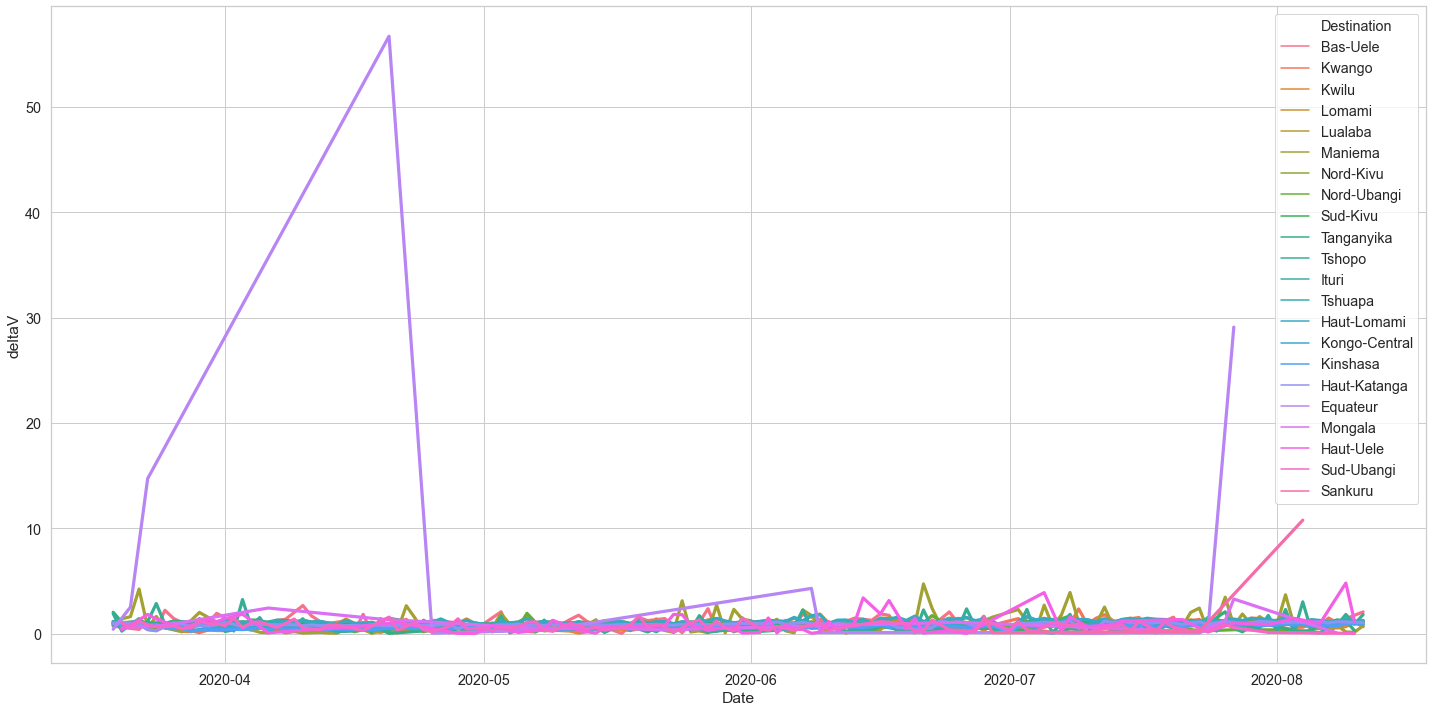

In [71]:
fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(x='Date',y='deltaV',data=df_trend, hue = 'Destination',linewidth = 3.2)

# ax.set_xticklabels(labels = df_total_flux['Date'], rotation=90)
# ax.

# sns.scatterplot(x='Date',y='Volume',data=df_temp[df_temp.Destination == 'Kinshasa' ], hue = 'Date_type', ax =ax, palette = ['#ffb300','b'])

# ax.axvline('2020-07-01',ymin = 0, ymax = 1,color = '#546e7a', ls = '--', linewidth = 2.5)

# ax.axvline('2020-06-10',ymin = 0, ymax = 1,color = 'r')
# ax.yaxis.set_major_formatter(ticker.EngFormatter())
# ax.set_xticklabels(labels=,rotation=45)
# plt.xlim(0)


plt.tight_layout()
plt.show()

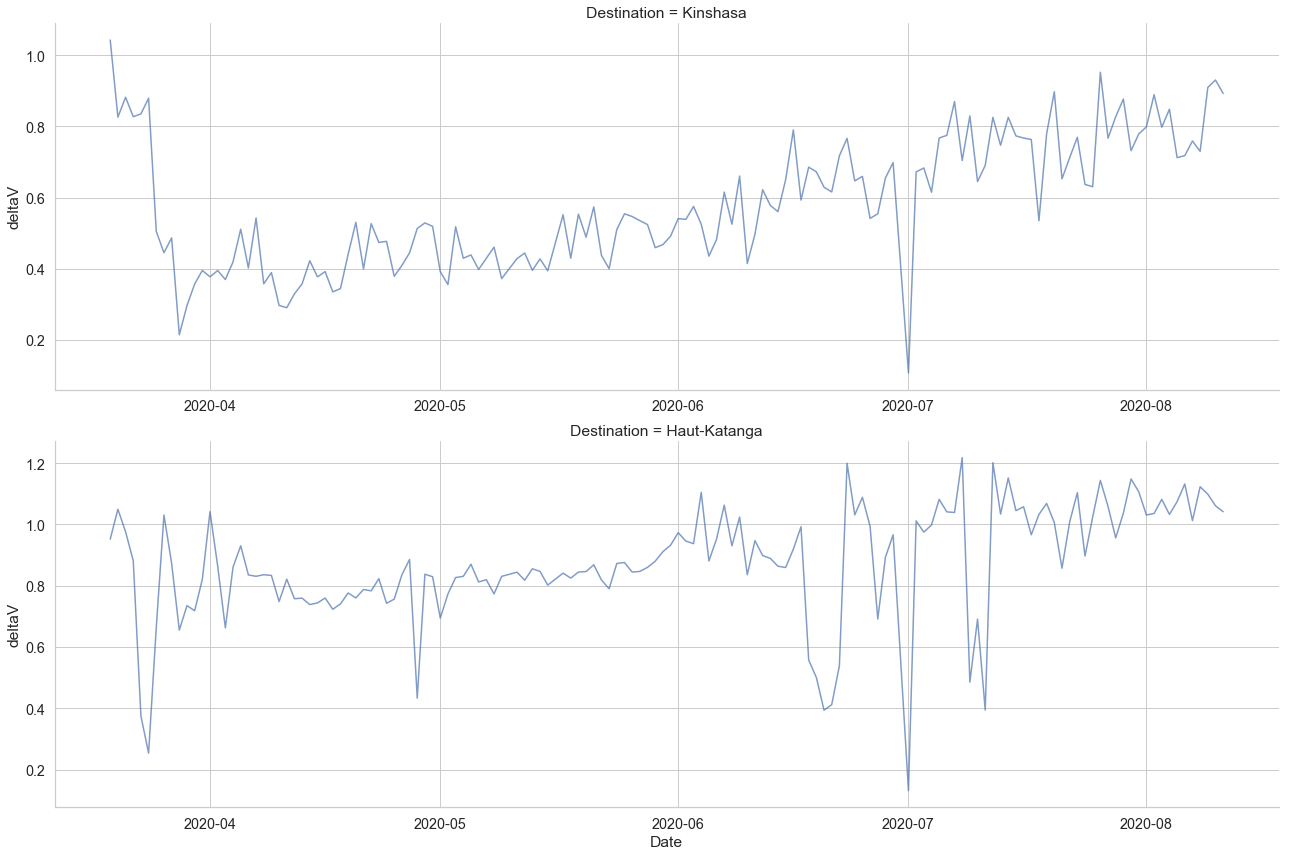

In [72]:
selected_zones = ['Kinshasa','Haut-Katanga']
g = sns.FacetGrid(df_trend[df_trend.Destination.isin(selected_zones)], row="Destination",aspect=3,height=6,sharey=False,sharex=False)
# g.map(sns.lineplot, x='Date',y='deltaV', alpha=.7)
g.map(plt.plot, "Date", "deltaV", alpha=.7)
# sns.lineplot(x='Date',y='deltaV',data=df_trend)
g.add_legend();

# Presence Data

In [73]:
# reading csv file
dfp = pd.read_csv('data/new/Zoning Province/Presence_24h.csv',sep = ';')
dfp

,Date,Day_type,PresenceType,Type,Activity_Zone,Home_Zone,Zone,Volume
0,2020-02-01,WE,Jour,Local,Hors_Zone,Hors_Zone,Tanganyika,679176
1,2020-02-01,WE,Nuit,Local,Hors_Zone,Hors_Zone,Tanganyika,350111
2,2020-02-01,WE,Jour,Local,Tanganyika,Hors_Zone,Tanganyika,770048
3,2020-02-01,WE,Nuit,Local,Tanganyika,Hors_Zone,Tanganyika,226845
4,2020-02-01,WE,Jour,Local,Haut-Katanga,Hors_Zone,Tanganyika,464
...,...,...,...,...,...,...,...,...
208455,2020-08-11,JO,Nuit,Etranger,Nord-Kivu,Hors_Zone,Nord-Kivu,1209
208456,2020-08-11,JO,Jour,Etranger,Hors_Zone,Nord-Kivu,Nord-Kivu,1403
208457,2020-08-11,JO,Nuit,Etranger,Hors_Zone,Nord-Kivu,Nord-Kivu,1782
208458,2020-08-11,JO,Jour,Etranger,Nord-Kivu,Nord-Kivu,Nord-Kivu,3835


In [74]:
#Duplicates check
dfp[dfp.duplicated()]

,Date,Day_type,PresenceType,Type,Activity_Zone,Home_Zone,Zone,Volume


In [75]:
#Convert to Date

dfp['Date'] = pd.to_datetime(dfp['Date'])

In [76]:
#filter by selected zones

dfp_filtered = dfp[dfp['Zone'].isin(list_filtered_zones)]
dfp_filtered

,Date,Day_type,PresenceType,Type,Activity_Zone,Home_Zone,Zone,Volume
0,2020-02-01,WE,Jour,Local,Hors_Zone,Hors_Zone,Tanganyika,679176
1,2020-02-01,WE,Nuit,Local,Hors_Zone,Hors_Zone,Tanganyika,350111
2,2020-02-01,WE,Jour,Local,Tanganyika,Hors_Zone,Tanganyika,770048
3,2020-02-01,WE,Nuit,Local,Tanganyika,Hors_Zone,Tanganyika,226845
4,2020-02-01,WE,Jour,Local,Haut-Katanga,Hors_Zone,Tanganyika,464
...,...,...,...,...,...,...,...,...
208455,2020-08-11,JO,Nuit,Etranger,Nord-Kivu,Hors_Zone,Nord-Kivu,1209
208456,2020-08-11,JO,Jour,Etranger,Hors_Zone,Nord-Kivu,Nord-Kivu,1403
208457,2020-08-11,JO,Nuit,Etranger,Hors_Zone,Nord-Kivu,Nord-Kivu,1782
208458,2020-08-11,JO,Jour,Etranger,Nord-Kivu,Nord-Kivu,Nord-Kivu,3835


In [77]:
df_agg_dzp = dfp_filtered.groupby(["Date","Zone",'PresenceType'],as_index=0).sum()
df_agg_dzp

,Date,Zone,PresenceType,Volume
0,2020-02-01,Bas-Uele,Jour,1034483
1,2020-02-01,Bas-Uele,Nuit,709632
2,2020-02-01,Equateur,Jour,1803206
3,2020-02-01,Equateur,Nuit,1419771
4,2020-02-01,Haut-Katanga,Jour,5629768
...,...,...,...,...
8223,2020-08-11,Tanganyika,Nuit,1568133
8224,2020-08-11,Tshopo,Jour,2799508
8225,2020-08-11,Tshopo,Nuit,2125865
8226,2020-08-11,Tshuapa,Jour,1675233


In [78]:
dfp_agg_f_day = df_agg_dzp#[df_agg_dzp.PresenceType == 'Nuit']
dfp_agg_date_zone = dfp_agg_f_day.groupby(by=['Date','Zone'],as_index=0).sum()
dfp_agg_date_zone

,Date,Zone,Volume
0,2020-02-01,Bas-Uele,1744115
1,2020-02-01,Equateur,3222977
2,2020-02-01,Haut-Katanga,9181926
3,2020-02-01,Haut-Lomami,5263402
4,2020-02-01,Haut-Uele,2264021
...,...,...,...
4109,2020-08-11,Sud-Kivu,10611755
4110,2020-08-11,Sud-Ubangi,3694226
4111,2020-08-11,Tanganyika,3933769
4112,2020-08-11,Tshopo,4925373


In [79]:
# dfp_agg_f_night = df_agg_dzp[df_agg_dzp.PresenceType == 'Nuit']
# dfp_agg_f_day = df_agg_dzp[df_agg_dzp.PresenceType == 'Day']

In [80]:
# dfp_agg_f_night

### Merging Presence and Movement

In [81]:
df_mvt_pres = df_filtered_both.merge(dfp_agg_date_zone,left_on=['Origin','Date'], right_on=['Zone','Date'])

#Total movers per day from an origin
df_mvt_pres_filtered = (df_mvt_pres[['Date','Origin', 'Volume_x']].groupby(by=['Date','Origin'], as_index=False).sum()).rename(columns={'Volume_x':'tot_from_origin'})
df_mvt_pres = df_mvt_pres.merge(df_mvt_pres_filtered,left_on=['Origin','Date'], right_on=['Origin','Date'])
#Proportion of movers
df_mvt_pres['move_prop'] = df_mvt_pres['Volume_x']/ df_mvt_pres['Volume_y'] # Proportion with respect to presence in the corresponding day
df_mvt_pres['move_prop_tot'] = df_mvt_pres['Volume_x']/ df_mvt_pres['tot_from_origin'] # Proportion with respect to total from origin in the corresponding day

df_mvt_pres[(df_mvt_pres.Date == '2020-02-1') & (df_mvt_pres.Origin == 'Haut-Lomami')]
# df_mvt_pres[(df_mvt_pres.Origin == 'Kinshasa') ]
# df_mvt_pres

,Date,Origin,Destination,Observation_Zone,Date_day,Volume_x,Zone,Volume_y,tot_from_origin,move_prop,move_prop_tot
7,2020-02-01,Haut-Lomami,Haut-Katanga,ZoneGlobale,5,689,Haut-Lomami,5263402,32563,0.000131,0.021159
8,2020-02-01,Haut-Lomami,Lomami,ZoneGlobale,5,28872,Haut-Lomami,5263402,32563,0.005485,0.886650
9,2020-02-01,Haut-Lomami,Lualaba,ZoneGlobale,5,3002,Haut-Lomami,5263402,32563,0.000570,0.092191


In [82]:
df_mvt_epi = df_mvt_pres.merge(df_pats, left_on='Origin', right_on='patNames')
df_mvt_epi = df_mvt_epi.merge(df_pats, left_on='Destination', right_on='patNames')
df_mvt_epi.drop(['patNames_x','patNames_y','Observation_Zone','Zone'],axis=1, inplace=True) #,'Date_day'
#"fr_users","movers"
df_mvt_epi.rename(columns={'Date':'date','Volume_x':'movers','patIDs_x':'fr_pat','patIDs_y':'to_pat','Volume_y':'fr_users'}, inplace=True)
df_mvt_epi

,date,Origin,Destination,Date_day,movers,fr_users,tot_from_origin,move_prop,move_prop_tot,fr_pat,to_pat
0,2020-02-01,Bas-Uele,Haut-Uele,5,1049,1744115,4238,0.000601,0.247522,1,5
1,2020-02-06,Bas-Uele,Haut-Uele,3,875,1741434,4464,0.000502,0.196013,1,5
2,2020-02-10,Bas-Uele,Haut-Uele,0,781,1761174,3906,0.000443,0.199949,1,5
3,2020-02-12,Bas-Uele,Haut-Uele,2,710,1767211,710,0.000402,1.000000,1,5
4,2020-02-14,Bas-Uele,Haut-Uele,4,752,1760713,2297,0.000427,0.327384,1,5
...,...,...,...,...,...,...,...,...,...,...,...
7497,2020-06-29,Nord-Kivu,Sankuru,0,50,14787320,113169,0.000003,0.000442,19,21
7498,2020-07-23,Nord-Kivu,Sankuru,3,83,14313779,103150,0.000006,0.000805,19,21
7499,2020-08-05,Nord-Kivu,Sankuru,2,27,14858971,111088,0.000002,0.000243,19,21
7500,2020-06-05,Tshopo,Sankuru,4,44,4939442,497,0.000009,0.088531,25,21


Trying to repeate mobility pattern for missing date

In [83]:
df_mvt_epi_wo_npi = df_mvt_epi[df_mvt_epi.date<'2020-03-18']
df_mvt_epi_wo_npi

,date,Origin,Destination,Date_day,movers,fr_users,tot_from_origin,move_prop,move_prop_tot,fr_pat,to_pat
0,2020-02-01,Bas-Uele,Haut-Uele,5,1049,1744115,4238,0.000601,0.247522,1,5
1,2020-02-06,Bas-Uele,Haut-Uele,3,875,1741434,4464,0.000502,0.196013,1,5
2,2020-02-10,Bas-Uele,Haut-Uele,0,781,1761174,3906,0.000443,0.199949,1,5
3,2020-02-12,Bas-Uele,Haut-Uele,2,710,1767211,710,0.000402,1.000000,1,5
4,2020-02-14,Bas-Uele,Haut-Uele,4,752,1760713,2297,0.000427,0.327384,1,5
...,...,...,...,...,...,...,...,...,...,...,...
7478,2020-03-09,Kinshasa,Sankuru,0,43,15901877,25798,0.000003,0.001667,10,21
7479,2020-03-10,Kinshasa,Sankuru,1,239,16052541,31464,0.000015,0.007596,10,21
7480,2020-03-16,Kinshasa,Sankuru,0,21,15841221,33640,0.000001,0.000624,10,21
7489,2020-02-18,Nord-Kivu,Sankuru,1,33,14894498,119260,0.000002,0.000277,19,21


In [84]:
#zone_w_issue

In [85]:
# df_mvt_w_issue = df_mvt_epi_wo_npi[(df_mvt_epi_wo_npi['Origin'].isin(zone_w_issue)) | (df_mvt_epi_wo_npi['Destination'].isin(zone_w_issue)) ]

In [86]:
# df_mvt_w_issue[df_mvt_w_issue.isna()]

### Check for missing dates

In [87]:
# pd.date_range('2020-01-31','2020-03-17',)
def check_missing_dates(df,start,end):
    return set([d.strftime('%Y-%m-%d') for d in pd.date_range(start,end,)]) - set(df.date.dt.date.astype(str))

In [88]:
# df_mvt_epi[df_mvt_epi.date == '2020-03-18']

In [89]:
df_mvt_epi_wo_npi[df_mvt_epi_wo_npi.date == '2020-02-05']

,date,Origin,Destination,Date_day,movers,fr_users,tot_from_origin,move_prop,move_prop_tot,fr_pat,to_pat


In [90]:
check_missing_dates(df_mvt_epi_wo_npi,'2020-02-01','2020-03-17')

{'2020-02-05', '2020-02-28', '2020-03-02'}

In [253]:
#df_mvt_epi_wo_npi.sort_values('date')

In [254]:
df_mvt_epi_wo_npi_slid = pd.DataFrame(df_mvt_epi_wo_npi, copy=True)
df_mvt_epi_wo_npi_slid['date'] = df_mvt_epi_wo_npi_slid ['date'] + pd.Timedelta(6, 'W')
df_mvt_epi_wo_npi_slid

,date,Origin,Destination,Date_day,movers,fr_users,tot_from_origin,move_prop,move_prop_tot,fr_pat,to_pat
0,2020-03-14,Bas-Uele,Haut-Uele,5,1049,1744115,4238,0.000601,0.247522,1,5
1,2020-03-19,Bas-Uele,Haut-Uele,3,875,1741434,4464,0.000502,0.196013,1,5
2,2020-03-23,Bas-Uele,Haut-Uele,0,781,1761174,3906,0.000443,0.199949,1,5
3,2020-03-25,Bas-Uele,Haut-Uele,2,710,1767211,710,0.000402,1.000000,1,5
4,2020-03-27,Bas-Uele,Haut-Uele,4,752,1760713,2297,0.000427,0.327384,1,5
...,...,...,...,...,...,...,...,...,...,...,...
7478,2020-04-20,Kinshasa,Sankuru,0,43,15901877,25798,0.000003,0.001667,10,21
7479,2020-04-21,Kinshasa,Sankuru,1,239,16052541,31464,0.000015,0.007596,10,21
7480,2020-04-27,Kinshasa,Sankuru,0,21,15841221,33640,0.000001,0.000624,10,21
7489,2020-03-31,Nord-Kivu,Sankuru,1,33,14894498,119260,0.000002,0.000277,19,21


In [255]:
# df_mvt_epi_slid = df_mvt_epi_slid[df_mvt_epi_slid.date > df_mvt_epi_wo_npi.date.max()] #>= df_mvt_epi_wo_npi.date.max()
# df_mvt_epi_slid

In [256]:
#Sliding data until december 2020

df_mvt_wo_npi_slid = slide_df(df_mvt_epi_wo_npi,6, 'W')
df_mvt_wo_npi_slid = slide_df(df_mvt_wo_npi_slid,12, 'W')
df_mvt_wo_npi_slid = slide_df(df_mvt_wo_npi_slid,16, 'W')
df_mvt_wo_npi_slid

,date,Origin,Destination,Date_day,movers,fr_users,tot_from_origin,move_prop,move_prop_tot,fr_pat,to_pat
0,2020-02-01,Bas-Uele,Haut-Uele,5,1049,1744115,4238,0.000601,0.247522,1,5
1,2020-02-06,Bas-Uele,Haut-Uele,3,875,1741434,4464,0.000502,0.196013,1,5
2,2020-02-10,Bas-Uele,Haut-Uele,0,781,1761174,3906,0.000443,0.199949,1,5
3,2020-02-12,Bas-Uele,Haut-Uele,2,710,1767211,710,0.000402,1.000000,1,5
4,2020-02-14,Bas-Uele,Haut-Uele,4,752,1760713,2297,0.000427,0.327384,1,5
...,...,...,...,...,...,...,...,...,...,...,...
7478,2020-11-02,Kinshasa,Sankuru,0,43,15901877,25798,0.000003,0.001667,10,21
7479,2020-11-03,Kinshasa,Sankuru,1,239,16052541,31464,0.000015,0.007596,10,21
7480,2020-11-09,Kinshasa,Sankuru,0,21,15841221,33640,0.000001,0.000624,10,21
7489,2020-10-13,Nord-Kivu,Sankuru,1,33,14894498,119260,0.000002,0.000277,19,21


In [257]:
check_missing_dates(df_mvt_wo_npi_slid,'2020-01-31','2020-11-08')

{'2020-01-31',
 '2020-02-05',
 '2020-02-28',
 '2020-03-02',
 '2020-03-18',
 '2020-04-10',
 '2020-04-13',
 '2020-04-29',
 '2020-05-22',
 '2020-05-25',
 '2020-06-10',
 '2020-07-03',
 '2020-07-06',
 '2020-07-31',
 '2020-08-03',
 '2020-08-19',
 '2020-09-11',
 '2020-09-14',
 '2020-09-30',
 '2020-10-23',
 '2020-10-26'}

In [258]:
# df_mvt_epi[(df_mvt_epi.Origin == 'Gombe')].mean()

In [259]:
# df_mvt_wo_npi_slid[(df_mvt_wo_npi_slid.Origin == 'Gombe')&(df_mvt_wo_npi_slid.date == '2020-11-08')].describe()

In [260]:
# df_mvt_epi[(df_mvt_epi.Origin == 'Kinshasa') & (df_mvt_epi.date == '2020-03-27')]['move_prop'].sum()

### Save OD matrix to csv

In [262]:
df_mvt_wo_npi_slid[['date','Origin','Destination','fr_pat', 'to_pat','movers','fr_users','move_prop','tot_from_origin','move_prop_tot']].to_csv('./epidemiological_model/BEARmod_DRC/data/mobmatmacro.csv')

In [205]:
#[(df_mvt_wo_npi_slid.date >= '2020-07-04')&((df_mvt_wo_npi_slid.date <= '2020-11-09'))]

# BEARmod
Basic Epidemic, Activity, and Response COVID-19 model

This model implements a basic SEIR simulation model, accounting for variable daily movement patterns, recovery rates, and contact rates. Demonstration of this model can be seen in a recent Nature paper [1]

For a placeholder dummy dataset and example simulation run, please see "run_model_small.R", which uses a dummy movement dataset "testmove.csv"

## Overall model
This model is a metapopulation model of COVID-19 transmission, based on an SEIR modeling framework. Within each patch, this model follows a fairly simple SEIR framework. The primary complexities this model is designed to describe are daily movement patterns, and spatially and temporally heterogeneous reductions in movement and contact rates. Specifically, this model is particularly suited for data that generally come from mobile phone companies.

### Baseline patch-level processes
Within each patch, this model first calculates the number of infected people who recovered or were otherwise removed from the infectious population (ie. through self-isolatuion) at an average rate r, where r is equal to the inverse of the average infectious period. This is explicitly incorporated as a Bernoulli trial for each infected person with a probability of recovering 1-exp⁡(-r). 
Then, the model converts exposed people to infectious by similarly incorporating a Bernoulli trial for each exposed individual, where the daily probability of becoming infectious 1-exp⁡(-ε), where ε was the inverse of the average time spent exposed but not infectious. 
Finally, to end the exposure, infection, and recovery step of the model, newly exposed people are calculated for each city based on the number of infectious people in the city I_i, and the average number of daily contacts that lead to transmission that each infectious person has c. This model then simulates the number of newly exposed people through a random draw from a Poisson distribution for each infectious person where the mean number of new infections per person was c, which was then multiplied by the fraction of people in the patch who are susceptible.
The infection processes within each patch therefore approximate the following deterministic, continuous-time model, where c and r varied through time:
dS/dt=S-c SI/N
dE/dt=c SI/N-εE
dI/dt=εE-rI
dR/dt=rI

### Movement between patches
After completing the infection-related processes, the model moves infectious people between cities, using the proportion of people who went from each patch to each other patch measured in the input OD matrix. Infectious people are moved from their current location to each possible destination (including remaining in the same place) using Bernoulli trials for each infectied person, and each possible destination city. 
Through this model, stochasticity in the numbers and places where COVID-19 appears between simulation runs in this model through variance in numbers of people becoming exposed, infectious, and removed/recovered, as well as variance in numbers of people moving from one city to another.

## Input options and formats
Note: These parameter specifications are relevant for v 0.92, denoted at the top of the bearmod_fx.R file.

First, you will create an empty population list HPop, using InitiatePop(). This function takes as inputs:
- pat_locator: A data frame with variables "patNames", "patIDs" (numeric; sequential from 1:number of patches), and "pop" (population per patch)
- initialInf: A vector of initially infected people per patch, length equal to the number of patches
- initialExp: A vector of initially exposed people per patch, length equal to the number of patches

The initial HPop is then fed into the runSim function, which has the following inputs:
- HPop
- pat_info: This is the same as pat_locator
- movement_reduction_df: a data frame with 3 variables, "date", "name", and "relative_movement". "name" corresponds to the patNames ID for the patch, and "relative_movement" indicates the relative proportion of movement for that day--.3 means all movement for that patch in that day (both incoming and outgoing) will be 30% of the baseline value (specified in mobmat later). This is specified on a per-day basis, and does not have to be complete--any missing day/patch pairs will have 100% of the baseline movement patterns
- contact_reduction_df: a data frame with 3 variables, "date", "name", and "relative_contact". Same as movement_reduction_df except this refers to the relative contact rate within a patch for a given day--ie. .5 means half as many contacts per person
- mobmat: A data frame with variables "date", "fr_pat", "to_pat", "move_prop". fr_pat and to_pat refer to the patch IDs of the origin and destination patches (see patIDs from pat_locator), and move_prop is the proportion of people who move from each origin to each destination on the given day in "date". If stayers are not denoted (origin = destination), then the model will designate this as 1 - sum(movement elsewhere) for a given patch. 

--more parameter definitions coming soon--

Contact:
Nick W Ruktanonchai; 
nrukt00 at gmail.com

[1] Lai, S., Ruktanonchai, N.W., Zhou, L. et al. Effect of non-pharmaceutical interventions to contain COVID-19 in China. Nature (2020). https://doi.org/10.1038/s41586-020-2293-x
